In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import textwrap
import math

In [2]:
class ComplexRadar():
    """
    Create a complex radar chart with different scales for each variable

    Parameters
    ----------
    fig : figure object
        A matplotlib figure object to add the axes on
    variables : list
        A list of variables
    ranges : list
        A list of tuples (min, max) for each variable
    n_ring_levels: int, defaults to 5
        Number of ordinate or ring levels to draw
    show_scales: bool, defaults to True
        Indicates if we the ranges for each variable are plotted
    format_cfg: dict, defaults to None
        A dictionary with formatting configurations

    """
    def __init__(self, fig, variables, ranges, n_ring_levels=5, show_scales=True, format_cfg=None):
        
        # Default formatting
        self.format_cfg = {
            # Axes
            # https://matplotlib.org/stable/api/figure_api.html
            'axes_args': {},
            # Tick labels on the scales
            # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.rgrids.html
            'rgrid_tick_lbls_args': {'fontsize':8},
            # Radial (circle) lines
            # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.grid.html
            'rad_ln_args': {},
            # Angle lines
            # https://matplotlib.org/3.2.2/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D
            'angle_ln_args': {},
            # Include last value (endpoint) on scale
            'incl_endpoint':False,
            # Variable labels (ThetaTickLabel)
            'theta_tick_lbls':{'va':'top', 'ha':'center'},
            'theta_tick_lbls_txt_wrap':15,
            'theta_tick_lbls_brk_lng_wrds':False,
            'theta_tick_lbls_pad':25,
            # Outer ring
            # https://matplotlib.org/stable/api/spines_api.html
            'outer_ring':{'visible':True, 'color':'#d6d6d6'}
        }
        
        if format_cfg is not None:
            self.format_cfg = { k:(format_cfg[k]) if k in format_cfg.keys() else (self.format_cfg[k]) 
                 for k in self.format_cfg.keys()}        
        
        
        # Calculate angles and create for each variable an axes
        # Consider here the trick with having the first axes element twice (len+1)
        angles = np.arange(0, 360, 360./len(variables))
        axes = [fig.add_axes([0.1,0.1,0.9,0.9], 
                             polar=True,
                             label = "axes{}".format(i),
                             **self.format_cfg['axes_args']) for i in range(len(variables)+1)]
        
        # Ensure clockwise rotation (first variable at the top N)
        for ax in axes:
            ax.set_theta_zero_location('N')
            ax.set_theta_direction(-1)
            ax.set_axisbelow(True)
        
        # Writing the ranges on each axes
        for i, ax in enumerate(axes):

            # Here we do the trick by repeating the first iteration
            j = 0 if (i==0 or i==1) else i-1
            ax.set_ylim(*ranges[j])
            # Set endpoint to True if you like to have values right before the last circle
            grid = np.linspace(*ranges[j], num=n_ring_levels, 
                               endpoint=self.format_cfg['incl_endpoint'])
            gridlabel = ["{}".format(round(x,2)) for x in grid]
            gridlabel[0] = "" # remove values from the center
            lines, labels = ax.set_rgrids(grid, 
                              labels=gridlabel, 
                              angle=angles[j],
                              **self.format_cfg['rgrid_tick_lbls_args']
                              )
            
            ax.set_ylim(*ranges[j])
            ax.spines["polar"].set_visible(False)
            ax.grid(visible=False)
            
            if show_scales == False:
                ax.set_yticklabels([])

        # Set all axes except the first one unvisible
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            
        # Setting the attributes
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
        self.ax1 = axes[1]
        self.plot_counter = 0
        
        
        # Draw (inner) circles and lines
        self.ax.yaxis.grid(**self.format_cfg['rad_ln_args'])
        # Draw outer circle
        self.ax.spines['polar'].set(**self.format_cfg['outer_ring'])
        # Draw angle lines
        self.ax.xaxis.grid(**self.format_cfg['angle_ln_args'])

        # ax1 is the duplicate of axes[0] (self.ax)
        # Remove everything from ax1 except the plot itself
        self.ax1.axis('off')
        self.ax1.set_zorder(9)
        
        # Create the outer labels for each variable
        l, text = self.ax.set_thetagrids(angles, labels=variables)
        
        # Beautify them
        labels = [t.get_text() for t in self.ax.get_xticklabels()]
        labels = ['\n'.join(textwrap.wrap(l, self.format_cfg['theta_tick_lbls_txt_wrap'], 
                            break_long_words=self.format_cfg['theta_tick_lbls_brk_lng_wrds'])) for l in labels]
        self.ax.set_xticklabels(labels, **self.format_cfg['theta_tick_lbls'])
        
        for t,a in zip(self.ax.get_xticklabels(),angles):
            # if a == 0:
            #     t.set_ha('center')
            # elif a > 0 and a < 180:
            #     t.set_ha('left')
            # elif a == 180:
            #     t.set_ha('center')
            # else:
            #     t.set_ha('right')
            t.set_ha('center')

        self.ax.tick_params(axis='both', pad=self.format_cfg['theta_tick_lbls_pad'])


    def _scale_data(self, data, ranges):
        """Scales data[1:] to ranges[0]"""
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            assert (y1 <= d <= y2) or (y2 <= d <= y1)
        x1, x2 = ranges[0]
        d = data[0]
        sdata = [d]
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            sdata.append((d-y1) / (y2-y1) * (x2 - x1) + x1)
        return sdata
        
    def plot(self, data, *args, **kwargs):
        """Plots a line"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)
        self.plot_counter = self.plot_counter+1
    
    def fill(self, data, *args, **kwargs):
        """Plots an area"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)
        
    def use_legend(self, *args, **kwargs):
        """Shows a legend"""
        self.ax1.legend(*args, **kwargs)
    
    def set_title(self, title, pad=25, **kwargs):
        """Set a title"""
        self.ax.set_title(title,pad=pad, **kwargs)
    
    def set_text(self, *args, **kwargs):
        self.ax.set_text(*args, **kwargs)

In [23]:
def plot_radar(df, data_min_max=None, method_styles=None, plot_idxs=None, alphas=None, colors=None, save_path='./radar_compare.pdf'):
    methods = df.index.values.tolist()
    data = df.to_dict('list')
    if data_min_max is None:
      data_min = df.apply(pd.to_numeric, errors='coerce').min(axis=0).to_dict()
      data_max = df.apply(pd.to_numeric, errors='coerce').max(axis=0).to_dict()
      data_min_max = {k: [data_min[k]-4, data_max[k]+4] for k in data_min}

    new_data = {}
    for k, v in data.items():
      v_min = data_min_max[k][0]
      new_v = []
      for vv in v:
        if vv == 'N/A':
          new_v.append(v_min)
        else:
          new_v.append(vv)
      new_data[k] = new_v

    data = new_data

    ranges = list(data_min_max.values())
    variables = data.keys()

    format_cfg = {
        'rad_ln_args': {'visible':True},
        'angle_ln_args':{'visible':True},
        'rgrid_tick_lbls_args': {'fontsize':10},
        'theta_tick_lbls_pad': 30,
        'outer_ring':{'visible':False, 'color':'#d6d6d6'},
        'theta_tick_lbls':{'va':'center', 'ha':'center', 'fontsize':12},
    }


    fig1 = plt.figure(figsize=(6, 6))
    radar = ComplexRadar(fig1, variables, ranges, n_ring_levels=4, show_scales=True, format_cfg=format_cfg)

    # custom_colors = ['#DDA0DD', '#F5C6D1', '#FAF7B6', '#C2F2FF', '#3CB371']
    # custom_colors = ['#F4A460', '#87CEFA', '#3CB371', '#FFD700', '#CD5C5C', '#DDA0DD', '#FF6347', '#6495ED']
    custom_colors = colors if colors else ['#F4A460', '#87CEFA', '#3CB371', '#FFD700', '#CD5C5C', '#DDA0DD', '#FF6347', '#6495ED']
    custom_alphas = alphas if alphas is not None else [0.2]*len(df)

    plot_idxs = plot_idxs if plot_idxs is not None else range(len(df))
    print(len(list(data.values())[0]), len(custom_colors), len(methods))
    for g in plot_idxs:
        if method_styles:
          styles = method_styles[methods[g]] if methods[g] in method_styles else method_styles['default']
          radar.plot([i[g] for i in list(data.values())], label=f"{methods[g]}", color=custom_colors[g], **styles)
        else:
          # radar.plot([i[g] for i in list(data.values())], label=f"{methods[g]}", color=custom_colors[g], linestyle='--', linewidth=0.8)
          radar.plot([i[g] for i in list(data.values())], label=f"{methods[g]}", color=custom_colors[g])
           
        radar.fill([i[g] for i in list(data.values())], alpha=custom_alphas[g], color=custom_colors[g])

    # radar.set_title("Radar chart solution with different scales", pad=25)
    radar.use_legend(**{'loc':'lower right', 'bbox_to_anchor':(1.6, -0.12), 'ncol':radar.plot_counter, 'fontsize':14, 'ncol':1, 'frameon':False})

    plt.text(0.56, 0.56, 'N/A', transform=plt.gcf().transFigure, fontsize=12)

    # plt.show() 
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')

In [18]:
def plot_stacked_bars(df, title="", figsize=(16,6), save_path=None):
    
    def label_bars(heights, rects, ypad=0):
        """Attach a text label on top of each bar."""
        for height, rect in zip(heights, rects):
            if height != 0:
                ax.annotate(f'{height}',
                            xy=(rect.get_x() + rect.get_width() / 2, height + ypad),
                            xytext=(0, 4),  # 4 points vertical offset.
                            textcoords='offset points',
                            ha='center', va='bottom')
            
    colors = ['#C71585', '#DCDCDC', '#FFE4C4']
    fig, ax = plt.subplots(figsize=figsize)
    init_width = 0.8
    width_decay = 0.9
    Xs = np.arange(len(df.columns))*1.5
    for i, (name, record) in enumerate(df.iterrows()):
        Ys = record.values.flatten()#.tolist()
        rects = ax.bar(Xs, Ys, init_width * width_decay**i, label=name, bottom=np.zeros(len(Xs)),
                   color=colors[i%len(colors)], edgecolor='black', linewidth=0.5)
        label_bars(Ys, rects, (-1)*(i%2)*10)
    ax.set_xlim(-0.5,Xs[-1]+0.5)
    
    plt.xticks(Xs, df.columns, rotation=30)
    plt.yticks(plt.yticks()[0], labels=['{}%'.format(round(y)) for y in plt.yticks()[0]])
    
    # plot auxiliary line
    plt.plot([-0.5, Xs[-1]+1], [100, 100], '--', color='gray')
    
    if title:
        ax.set_title(title)
    # ax.legend(loc="upper right", bbox_to_anchor=(1.8, 1.1))
    ax.legend(loc="upper left")
    if save_path:
        fig.savefig(save_path, dpi=100)

7 8 7


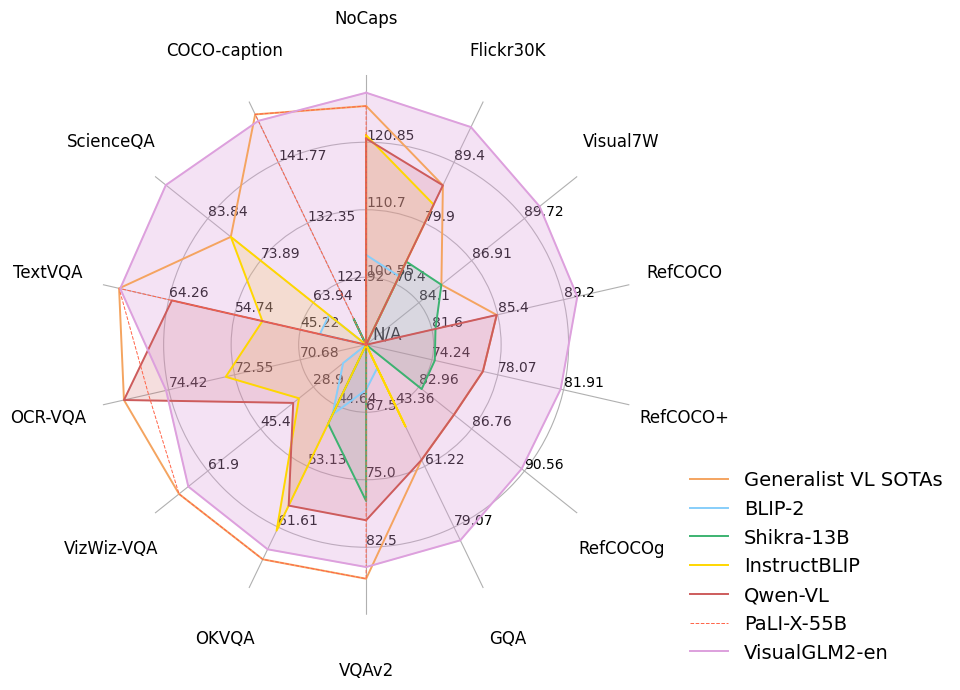

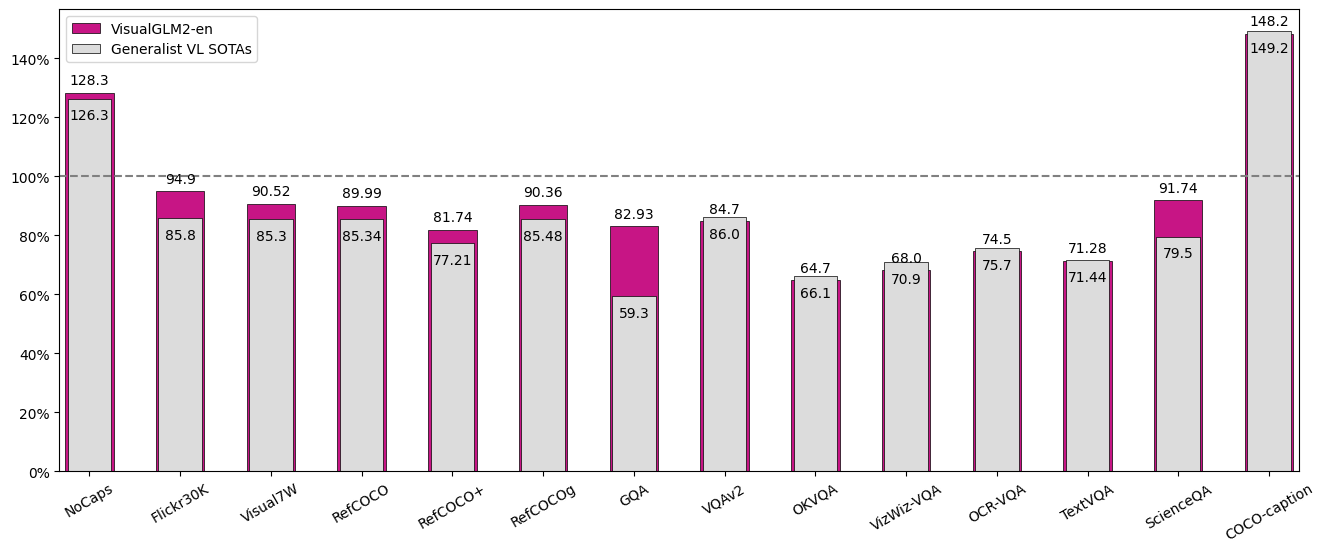

In [44]:

df = pd.DataFrame(
    [
     ['N/A', 71.6, 103.9, 'N/A', 'N/A', 'N/A', 'N/A', 45.9, 65., 32.3, 19.6, 'N/A', 'N/A', 42.4, 61.],
     [117.5 ,  73.9 ,   'N/A' ,  85.3 ,  81.81,  74.41,  83.16,  47.16, 77.36,   'N/A'   ,  'N/A'  ,  'N/A'  ,   'N/A'  , 'N/A', 'N/A'],
     [ 'N/A'  ,  82.8 , 121.9 , 'N/A' ,  'N/A' , 'N/A' ,  'N/A'  ,  62.1 ,'N/A'  ,  49.5 ,  33.4 ,  72.8 ,  'N/A' ,  50.7, 79.5],
     [ 'N/A'  ,  85.8 , 121.4 , 'N/A'  ,  85.34,  77.21,  85.48,  58.6 , 79.5 ,  59.3 ,  35.2 ,  75.7 ,  65.1 ,  63.8, 'N/A'],
     [149.1 , 'N/A' , 127.  ,  'N/A'  ,   'N/A'   ,  'N/A'  ,   'N/A'  ,  64.5 , 84.3 ,  'N/A' ,  74.4 ,  'N/A'  ,  'N/A' ,  71.81, 'N/A'],
     [149.2 , 'N/A'  , 126.3 ,  'N/A'  ,   'N/A'  ,   'N/A'  ,  'N/A'  ,  66.1 , 86.  ,  'N/A'  ,  70.9 ,  75. ,  80. ,  71.44, 'N/A'],
     [148.2 ,  94.9 , 128.3  ,  90.52,  89.99,  81.74,  90.36,  64.7 , 84.7 ,  82.93,  68.  ,  74.5 ,  66.1 ,  71.28, 91.74]],
    columns = ['COCO-caption', 'Flickr30K', 'NoCaps', 'Visual7W', 'RefCOCO', 'RefCOCO+', 'RefCOCOg', 'OKVQA', 'VQAv2',
                'GQA', 'VizWiz-VQA', 'OCR-VQA', 'Doc-VQA', 'TextVQA', 'ScienceQA'],
    index = ['BLIP-2', 'Shikra-13B', 'InstructBLIP', 'Qwen-VL', 'PaLI-17B', 'PaLI-X-55B', 'VisualGLM2-en']
)
df = df.reindex(columns=['NoCaps', 'Flickr30K', 'Visual7W', 'RefCOCO', 'RefCOCO+', 'RefCOCOg', 'GQA', 'VQAv2',
                'OKVQA', 'VizWiz-VQA', 'OCR-VQA', 'Doc-VQA', 'TextVQA', 'ScienceQA', 'COCO-caption'])
df = df.drop(index=['PaLI-17B'])
df = df.drop(columns=['Doc-VQA'])
df.loc['Generalist VL SOTAs'] = df.drop(index=['VisualGLM2-en']).apply(pd.to_numeric, errors='coerce').max(axis=0).values
df = df.reindex(['Generalist VL SOTAs'] + df.index.values.tolist()[:-1])

data_min_max = {
 'NoCaps': [90.4, 131.0],
 'Flickr30K': [60.9, 98.9],
 'Visual7W': [81.3, 92.52],
 'RefCOCO': [77.81, 92.99],
 'RefCOCO+': [70.41, 85.74],
 'RefCOCOg': [79.16, 94.36],
 'GQA': [25.5, 96.93],
 'VQAv2': [60., 90.0],
 'OKVQA': [36.16, 70.1],
 'VizWiz-VQA': [12.4, 78.4],
 'OCR-VQA': [68.8, 76.3],
#  'Doc-VQA': [61.099999999999994, 90.8],
 'TextVQA': [35.7, 73.78],
 'ScienceQA': [54, 93.78],
 'COCO-caption': [113.5, 151.2],
 }

# method_styles = {'PaLI-X-55B': {'linestyle': '--', 'linewidth': 1.0}, 'default': {'linestyle': '--', 'linewidth': 1.}}
method_styles = {'PaLI-X-55B': {'linestyle': '--', 'linewidth': 0.7}, 'default': {'linestyle': '-', 'linewidth': 1.4}}


# Plots
plot_radar(df, data_min_max=data_min_max, alphas=[0.0,0.1,0.2,0.2,0.2,0.0,0.3], method_styles=method_styles, colors=['#F4A460', '#87CEFA', '#3CB371', '#FFD700', '#CD5C5C', '#FF6347', '#DDA0DD', '#6495ED'], save_path='radar_compare.pdf')
plot_stacked_bars(df.loc[['VisualGLM2-en', 'Generalist VL SOTAs']], save_path='bars_compare.pdf')